# Plot LST/NDVI

## Introduction

After computing the mean, median, minimum, maximum, and standard deviation of LST/NDVI in each HOLC division and summarizing those values by HOLC grade and borough, we want to plot the results. 

There are two types of aggregated data:

1. In `summary_stats_agg`, we have one LST file and one NDVI file, where each row contains the average median value LST/NDVI grouped by HOLC grade for a single Landsat scene. 
2. In `summary_stats_temporal` we have an LST and NDVI file for every decade that we consider. In each file is the average median LST/NDVI for a specific HOLC boundary over that time period. 

In this notebook, we plot results from both files. Section 1 uses the aggregated statiistics from `summary_stats_agg`, and Section 2 uses data from `summary_stats_temporal`. For the first type of aggregated statistics, we plot

- [Section 1A](#agg-box-whisker) Box and whisker plots for the LST/NDVI for each HOLC grade across NYC.
- [Section 1B](#agg-box-whisker-boro) Box and whisker plots for the LST/NDVI for each HOLC grade for every borough.
- [Section 1C](#agg-time) LST/NDVI for each HOLC grade over time. 
- [Section 1D](#agg-decade) LST/NDVI grouped by decade for each HOLC grade. 

For the second type, we plot,

- [Section 2A](#agg-box-whisker-temp) Box and whisker plots for the LST/NDVI for each HOLC grade across NYC for each decade
- [Section 2B](#agg-decade-temp) LST/NDVI grouped by decade for each HOLC grade. 

## Data

Data is imported from the `02-data/summary_stats_agg/` and `02-data/summary_stats_agg-temporal/` folders. Figures are exported to the `03-figs/` folder of the parent directory.

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DIR_PARENT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DIR_DATA = DIR_PARENT + "/02-data"
DIR_STATS_AGG = DIR_DATA + "/summary_stats_agg"
DIR_STATS_T = DIR_DATA + "/summary_stats_temporal"

DIR_FIGS = DIR_PARENT + "/03-figs"

loc_years = ["NYBrooklyn1938","NYBronx1938","NYManhattan1937",
             "NYStatenIsland1940","NYQueens1938"]
lbls_boros = ["Brooklyn","Bronx","Manhattan","StatenIsland","Queens"]
lbls_plot = ["LST", "NDVI"]
lbls_y = ["LST (Kelvin)", "NDVI"]
lbls_yr = ["1984-1993", "1994-2002", "2003-2012", "2013-2022"]
prefix_fname = ["lst", "ndvi"]

# START FUNCTION DEFINITIONS
def convertKtoF(tempK):
    return (tempK-273.15)*9/5+32 

def parse_date_source_file_col(df):
    return pd.to_datetime(df["source_file"].apply(lambda x: x.split("_")[6]))

def datetime_year(y): 
    return pd.to_datetime("1Jan"+str(y))

## Section 1

Import data here. 

In [75]:
## USER INPUTS ################################################################
pixelfrac_filter = 0.9 # OPTIONS: 0.0, 0.8, 0.9
obs_choice = 0 # OPTIONS: 1=LST, 2=NDVI
## END USER INPUTS ############################################################

df_stats = pd.read_csv(DIR_STATS_AGG + "/ext_"+prefix_fname[obs_choice]+\
                        "_filt"+str(pixelfrac_filter)+\
                        "_mean_stats_combined.csv")

# Drop the row that contains the HOLC grade E. This comes from the Bronx 
# boundary file. 
df_stats = df_stats[df_stats["holc_grade"]!="E"]

# Add a datetime column to the data
df_stats["datetime"] = parse_date_source_file_col(df_stats)

### A. Box-and-whisker plot for NYC <a id=agg-box-whisker></a>

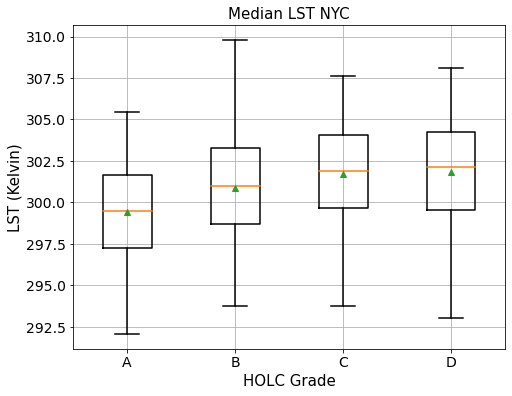

In [76]:
## USER INPUTS ###############################################################
font_size = 15
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS ###########################################################

plt.rcParams["figure.figsize"] = (7.5,6)
ax = df_stats[df_stats["loc_year"]=="NYC"].boxplot(
                column=[column_choice], 
                by=["holc_grade"],
                grid=True,
                showmeans=True,
                showfliers=False,
                color=dict(boxes='r', whiskers='r', medians='r', 
                           caps='r'),
                boxprops=dict(linestyle='-', linewidth=1.5),
                flierprops=dict(linestyle='-', linewidth=1.5),
                medianprops=dict(linestyle='-', linewidth=1.5),
                whiskerprops=dict(linestyle='-', linewidth=1.5),
                capprops=dict(linestyle='-', linewidth=1.5),
                fontsize=font_size-1)

ax.set_xlabel("HOLC Grade", fontsize=font_size)
ax.set_ylabel(lbls_y[obs_choice], fontsize=font_size)
fig = ax.get_figure()
fig.suptitle("") # Remove default Pandas title
plt.title("Median "+lbls_plot[obs_choice]+" NYC", fontsize=font_size)
plt.savefig(DIR_FIGS + "/boxplot_nyc_"+column_choice+"_"+\
            prefix_fname[obs_choice]+"_filt"+str(pixelfrac_filter)+".png",
            bbox_inches="tight")

### B. Box-and-whisker plot by borough <a id=agg-box-whisker-boro></a>

Text(0.5, 1.0, 'Median LST Queens')

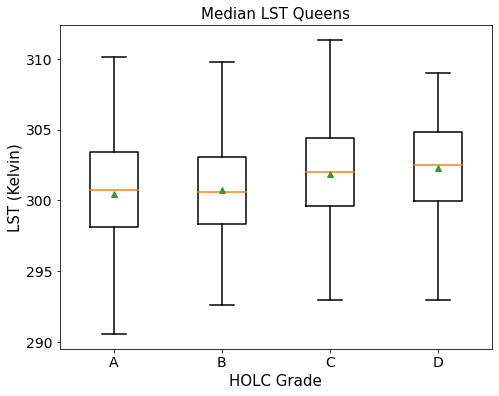

In [38]:
## USER INPUTS #################################################################
loc_year_choice = 4 # OPTIONS: 0 through 4
## END USER INPUTS #############################################################

column_choice = "median" # OPTIONS: median, mean, min, max, std
plt.rcParams["figure.figsize"] = (7.5,6)
font_size = 15
ax = df_stats[df_stats["loc_year"]==loc_years[loc_year_choice]].boxplot(
                column=[column_choice], 
                by=["holc_grade"],
                grid=False,
                showmeans=True,
                showfliers=False,
                color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
                boxprops=dict(linestyle='-', linewidth=1.5),
                flierprops=dict(linestyle='-', linewidth=1.5),
                medianprops=dict(linestyle='-', linewidth=1.5),
                whiskerprops=dict(linestyle='-', linewidth=1.5),
                capprops=dict(linestyle='-', linewidth=1.5),
                fontsize=font_size-1)

ax.set_xlabel("HOLC Grade", fontsize=font_size)
ax.set_ylabel(lbls_y[obs_choice], fontsize=font_size)
fig = ax.get_figure()
fig.suptitle("") # Remove default Pandas title
plt.title("Median " + lbls_plot[obs_choice]+ " " + lbls_boros[loc_year_choice],
          fontsize=font_size)
# plt.savefig(DIR_FIGS + "/boxplot_"+lbls_boros[loc_year_choice]+"_"+
            # column_choice+"_"+prefix_fname[obs_choice]+".png",bbox_inches = "tight")

### C. Observables vs. Time <a id="agg-time"></a>

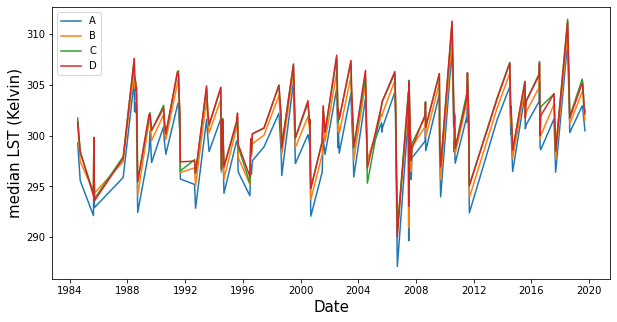

In [44]:
## USER INPUTS ###############################################################
font_size = 15
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS ###########################################################

df_stats_sorted = df_stats.sort_values(by="datetime")

plt.rcParams["figure.figsize"] = (10,5)

xvals_nyc =  df_stats_sorted[(
    df_stats_sorted["holc_grade"]=="A") & \
    (df_stats_sorted["loc_year"]=="NYC")]["datetime"].values

plt.plot(xvals_nyc, df_stats_sorted[(
    df_stats_sorted["holc_grade"]=="A") & \
    (df_stats_sorted["loc_year"]=="NYC")][column_choice], label="A")
plt.plot(xvals_nyc, df_stats_sorted[(
    df_stats_sorted["holc_grade"]=="B") & \
    (df_stats_sorted["loc_year"]=="NYC")][column_choice], label="B")
plt.plot(xvals_nyc, df_stats_sorted[(
    df_stats_sorted["holc_grade"]=="C") & \
    (df_stats_sorted["loc_year"]=="NYC")][column_choice], label="C")
plt.plot(xvals_nyc, df_stats_sorted[(
    df_stats_sorted["holc_grade"]=="D") & \
    (df_stats_sorted["loc_year"]=="NYC")][column_choice], label="D")

plt.legend(loc='upper left');

plt.xlabel("Date", fontsize = font_size)
plt.ylabel(column_choice + " "+ lbls_y[obs_choice], fontsize=font_size)

plt.savefig(DIR_FIGS + "/"+column_choice+"-"+prefix_fname[obs_choice]+\
            "-vs-time"+"_filt"+str(pixelfrac_filter)+".png")

### D. Group results by decade <a id="agg-decade"></a>

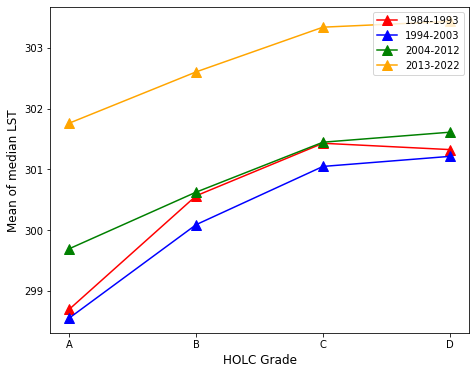

In [73]:
## USER INPUTS #####################################################################
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS #################################################################

plt.rcParams["figure.figsize"] = (7.5,6)

df_decade1 = df_stats[
    (df_stats["datetime"] >= datetime_year(1984)) & \
    (df_stats["datetime"] < datetime_year(1994))]
df_decade2 = df_stats[
    (df_stats["datetime"] >= datetime_year(1994)) & \
    (df_stats["datetime"] < datetime_year(2004))]
df_decade3 = df_stats[
    (df_stats["datetime"] >= datetime_year(2004)) & \
    (df_stats["datetime"] < datetime_year(2013))]
df_decade4 = df_stats[
    (df_stats["datetime"] >= datetime_year(2013)) & \
    (df_stats["datetime"] <= datetime_year(2022))]

font_size = 12
HOLC_grade = ["A", "B", "C", "D"]

plt.plot(HOLC_grade, df_decade1.groupby("holc_grade").mean()[column_choice],
           marker="^", markersize=10, c="r", label="1984-1993")
plt.plot(HOLC_grade, df_decade2.groupby("holc_grade").mean()[column_choice],
           marker="^", markersize=10, c="b", label="1994-2003")
plt.plot(HOLC_grade, df_decade3.groupby("holc_grade").mean()[column_choice],
           marker="^", markersize=10, c="g", label="2004-2012")
plt.plot(HOLC_grade, df_decade4.groupby("holc_grade").mean()[column_choice],
           marker="^", markersize=10, c="orange", label="2013-2022")
plt.legend(loc="upper right")


plt.xlabel("HOLC Grade", fontsize=font_size)
plt.ylabel("Mean of " + column_choice + " "+lbls_plot[obs_choice], fontsize=font_size)

plt.savefig(DIR_FIGS + "/"+column_choice+"-"+prefix_fname[obs_choice]+
            "-vs-HOLC_decades"+"_filt"+str(pixelfrac_filter)+".png")

### Plot the absolute difference from HOLC A

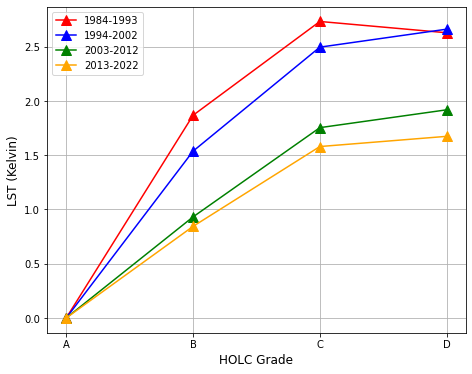

In [74]:
## USER INPUTS #####################################################################
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS #################################################################

plt.rcParams["figure.figsize"] = (7.5,6)

df_decade1 = df_stats[(df_stats["datetime"] >= datetime_year(1984)) & \
          (df_stats["datetime"] < datetime_year(1994))]
df_decade2 = df_stats[(df_stats["datetime"] >= datetime_year(1994)) & \
          (df_stats["datetime"] < datetime_year(2004))]
df_decade3 = df_stats[(df_stats["datetime"] >= datetime_year(2004)) & \
          (df_stats["datetime"] < datetime_year(2013))]
df_decade4 = df_stats[(df_stats["datetime"] >= datetime_year(2013)) & \
          (df_stats["datetime"] <= datetime_year(2022))]

font_size = 12
HOLC_grade = ["A", "B", "C", "D"]

decade1_Amean = df_decade1.groupby("holc_grade").mean()[column_choice][0]
plt.plot(HOLC_grade, 
    abs(df_decade1.groupby("holc_grade").mean()[column_choice]-
    decade1_Amean),marker="^", markersize=10, c="r", label="1984-1993")

decade2_Amean = df_decade2.groupby("holc_grade").mean()[column_choice][0]
plt.plot(HOLC_grade, 
    abs(df_decade2.groupby("holc_grade").mean()[column_choice]-
    decade2_Amean),marker="^", markersize=10, c="b", label="1994-2002")

decade3_Amean = df_decade3.groupby("holc_grade").mean()[column_choice][0]
plt.plot(HOLC_grade, abs(
    df_decade3.groupby("holc_grade").mean()[column_choice]-decade3_Amean),
           marker="^", markersize=10, c="g", label="2003-2012")

decade4_Amean = df_decade4.groupby("holc_grade").mean()[column_choice][0]
plt.plot(HOLC_grade, abs(
    df_decade4.groupby("holc_grade").mean()[column_choice]-decade4_Amean),
           marker="^", markersize=10, c="orange", label="2013-2022")

plt.legend(loc="upper left")
plt.grid()
    
# plt.title(obs_label + " - "+ obs_label + "(HOLC_A)")
plt.xlabel("HOLC Grade", fontsize=font_size)
plt.ylabel(lbls_y[obs_choice], fontsize=font_size)

plt.savefig(DIR_FIGS + "/"+column_choice+"-"+prefix_fname[obs_choice]+
            "-vs-HOLC_decades-difference"+"_filt"+\
            str(pixelfrac_filter)+".png")

## 2. Temporal statistics

Import data here.

In [110]:
## USER INPUTS #####################################################################
yr = 0 # OPTIONS: 0 to 3
pixelfrac_filter = 0.9 # OPTIONS: 0.0, 0.8, or 0.9
obs_choice = 0 # OPTIONS: 1=LST, 2=NDVI
## END USER INPUTS #################################################################

importname = DIR_STATS_T + "/ext_"+prefix_fname[obs_choice]+"_yr"+str(yr)+"_"+"pfilt"+str(pixelfrac_filter)+".csv"
df_mean_stats = pd.read_csv(importname)
df_mean_stats = df_mean_stats[df_mean_stats["holc_grade"]!="E"]

### A. Box-and-whisker plot in NYC by decade <a id="agg-box-whisker-temp"></a>

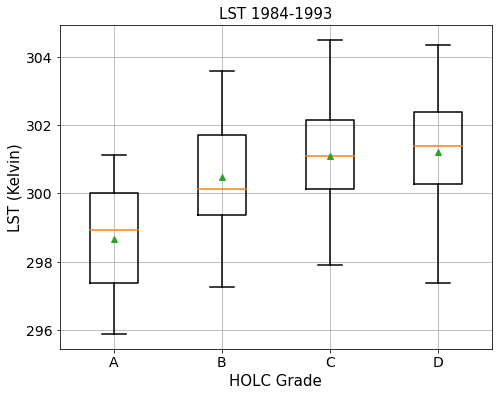

In [111]:
## USER INPUTS #####################################################################
font_size = 15
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS #################################################################

plt.rcParams["figure.figsize"] = (7.5,6)
ax = df_mean_stats.boxplot(
                column=[column_choice], 
                by=["holc_grade"],
                grid=False,
                showmeans=True,
                showfliers=False,
                color=dict(boxes='r', whiskers='r', medians='r', 
                           caps='r'),
                boxprops=dict(linestyle='-', linewidth=1.5),
                flierprops=dict(linestyle='-', linewidth=1.5),
                medianprops=dict(linestyle='-', linewidth=1.5),
                whiskerprops=dict(linestyle='-', linewidth=1.5),
                capprops=dict(linestyle='-', linewidth=1.5),
                fontsize=font_size-1)

plt.grid()
ax.set_xlabel("HOLC Grade", fontsize=font_size)
ax.set_ylabel(lbls_y[obs_choice], fontsize=font_size)
fig = ax.get_figure()
fig.suptitle("") # Remove default Pandas title
plt.title(lbls_plot[obs_choice]+" "+lbls_yr[yr], fontsize=font_size)
plt.savefig(DIR_FIGS + "/boxplot_nyc_"+column_choice+"_lst"+"_filt"+\
            str(pixelfrac_filter)+".png",
            bbox_inches="tight")

## B. Average median observable plotted for all decades <a id="agg-decade-temp"></a>

Text(0, 0.5, 'Mean of MedianLST (Kelvin)')

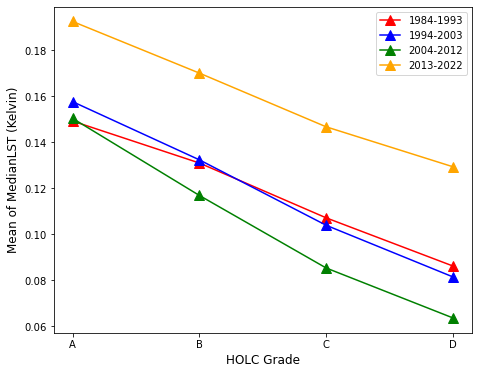

In [78]:
## USER INPUTS #####################################################################
pixelfrac_filter = 0.8 # OPTIONS: 0.0, 0.8, or 0.9
obs_choice = 0 # OPTIONS: 0 for LST and 1 for NDVI
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS #################################################################

plt.rcParams["figure.figsize"] = (7.5,6)

df_mean_stats0 = pd.read_csv(DIR_STATS_T + "/ext_"+prefix_fname[obs_choice]+"_yr0_"+"pfilt"+str(pixelfrac_filter)+".csv")
df_mean_stats1 = pd.read_csv(DIR_STATS_T + "/ext_"+prefix_fname[obs_choice]+"_yr1_"+"pfilt"+str(pixelfrac_filter)+".csv")
df_mean_stats2 = pd.read_csv(DIR_STATS_T + "/ext_"+prefix_fname[obs_choice]+"_yr2_"+"pfilt"+str(pixelfrac_filter)+".csv")
df_mean_stats3 = pd.read_csv(DIR_STATS_T + "/ext_"+prefix_fname[obs_choice]+"_yr3_"+"pfilt"+str(pixelfrac_filter)+".csv")

font_size = 12
HOLC_grade = ["A", "B", "C", "D"]

plt.plot(HOLC_grade, df_mean_stats0.groupby("holc_grade").mean()[column_choice][:-1],
           marker="^", markersize=10, c="r", label="1984-1993")
plt.plot(HOLC_grade, df_mean_stats1.groupby("holc_grade").mean()[column_choice][:-1],
           marker="^", markersize=10, c="b", label="1994-2003")
plt.plot(HOLC_grade, df_mean_stats2.groupby("holc_grade").mean()[column_choice][:-1],
           marker="^", markersize=10, c="g", label="2004-2012")
plt.plot(HOLC_grade, df_mean_stats3.groupby("holc_grade").mean()[column_choice][:-1],
           marker="^", markersize=10, c="orange", label="2013-2022")

plt.legend(loc="upper right")
plt.xlabel("HOLC Grade", fontsize=font_size)
plt.ylabel("Mean of Median" + lbls_y[obs_choice], fontsize=font_size)

# plt.savefig(DIR_FIGS + "/"+column_choice+"-"+obs_label+
#             "-vs-HOLC_decades.png")

#### Plot the difference from the HOLC A value

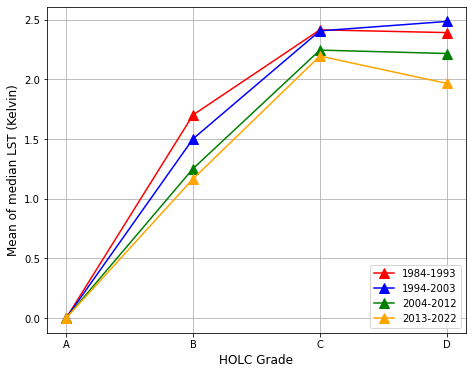

In [115]:
## USER INPUTS #####################################################################
pixelfrac_filter = 0.0 # OPTIONS: 0.0, 0.8, or 0.9
obs_choice = 0 # OPTIONS: 0 for LST and 1 for NDVI
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS #################################################################


plt.rcParams["figure.figsize"] = (7.5,6)
df_mean_stats0 = pd.read_csv(DIR_STATS_T + "/ext_"+prefix_fname[obs_choice]+"_yr0_"+"pfilt"+str(pixelfrac_filter)+".csv")
df_mean_stats1 = pd.read_csv(DIR_STATS_T + "/ext_"+prefix_fname[obs_choice]+"_yr1_"+"pfilt"+str(pixelfrac_filter)+".csv")
df_mean_stats2 = pd.read_csv(DIR_STATS_T + "/ext_"+prefix_fname[obs_choice]+"_yr2_"+"pfilt"+str(pixelfrac_filter)+".csv")
df_mean_stats3 = pd.read_csv(DIR_STATS_T + "/ext_"+prefix_fname[obs_choice]+"_yr3_"+"pfilt"+str(pixelfrac_filter)+".csv")

font_size = 12
HOLC_grade = ["A", "B", "C", "D"]

decade0_Amean = df_mean_stats0.groupby("holc_grade").mean()[column_choice][0]
plt.plot(HOLC_grade, abs(df_mean_stats0.groupby("holc_grade").mean()[column_choice][:-1]-decade0_Amean),
           marker="^", markersize=10, c="r", label="1984-1993")
decade1_Amean = df_mean_stats1.groupby("holc_grade").mean()[column_choice][0]
plt.plot(HOLC_grade, abs(df_mean_stats1.groupby("holc_grade").mean()[column_choice][:-1]-decade1_Amean),
           marker="^", markersize=10, c="b", label="1994-2003")
decade2_Amean = df_mean_stats2.groupby("holc_grade").mean()[column_choice][0]
plt.plot(HOLC_grade, abs(df_mean_stats2.groupby("holc_grade").mean()[column_choice][:-1]-decade2_Amean),
           marker="^", markersize=10, c="g", label="2004-2012")
decade3_Amean = df_mean_stats3.groupby("holc_grade").mean()[column_choice][0]
plt.plot(HOLC_grade, abs(df_mean_stats3.groupby("holc_grade").mean()[column_choice][:-1]-decade3_Amean),
           marker="^", markersize=10, c="orange", label="2013-2022")
plt.grid()
plt.legend(loc="lower right")
plt.xlabel("HOLC Grade", fontsize=font_size)
plt.ylabel("Mean of median "+lbls_y[obs_choice], fontsize=font_size)

plt.savefig(DIR_FIGS + "/"+column_choice+"-"+prefix_fname[obs_choice]+
            "-vs-HOLC_decades"+"_filt"+\
            str(pixelfrac_filter)+".png")